In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
import math
import mlflow
from mlflow.models.signature import infer_signature

In [17]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
min_max_scaler = MinMaxScaler()
standar_scaler = StandardScaler()
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng)

In [18]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

def porcentaje_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((data < BI) | (data > BS))
    print("Porcentaje de outliers: ", 100*out.sum()/out.count())

def quitar_outliers(data, df_feature):
    Q1 = df_feature.quantile(0.25)
    Q3 = df_feature.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((df_feature > BI) & (df_feature < BS))
    data = data.loc[out]
    return data

In [19]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')
df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [21]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
#Eliminar signo de interrogación de modelo y calcular valores únicos
df.Model = df.Model.apply(lambda x: x.replace('?', ''))
print("Valores únicos de modelos: ",len(df.Model.value_counts()))

Valores únicos de modelos:  319


In [23]:
#Encoder Fuel Type
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [24]:
drop_columns = ['Model', 'Id', 'Cylinders']

In [25]:
df = df.drop(columns=drop_columns)

#### Definir x e y

In [26]:
y = df.Price
x = df.drop(columns=['Price'])
names=pd.DataFrame(x.columns)

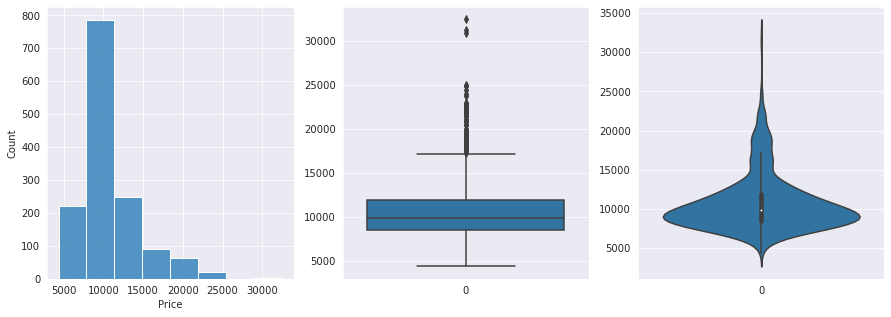

In [27]:
#Si modifico la variable price
graficar_info_variable(df.Price)

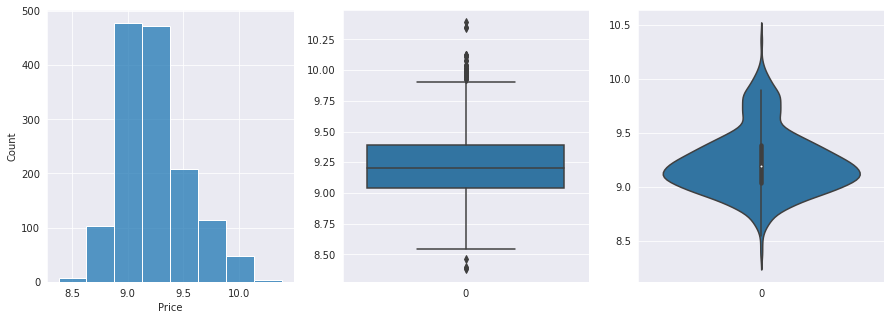

In [28]:
df.Price = np.log(df.Price)
graficar_info_variable(df.Price)

In [29]:
porcentaje_outliers(df.Price)

Porcentaje de outliers:  2.8551532033426184


In [30]:
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  1.6487455197132617


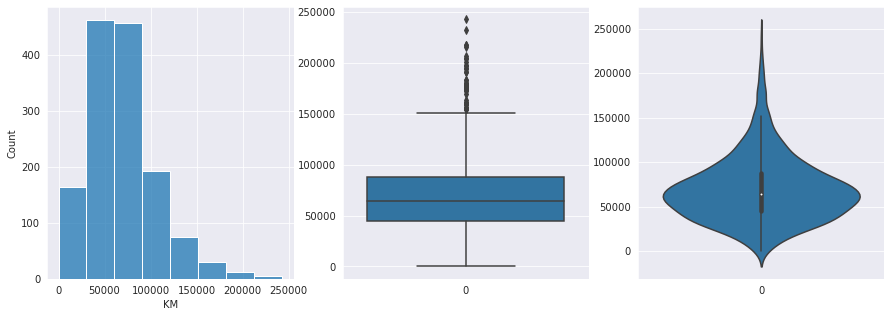

In [31]:
graficar_info_variable(df.KM)

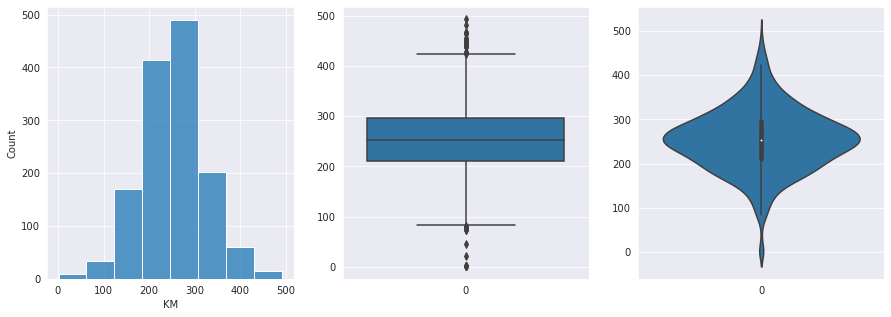

In [32]:
df.KM = np.sqrt(df.KM)
graficar_info_variable(df.KM)

In [33]:
porcentaje_outliers(df.KM)

Porcentaje de outliers:  2.4372759856630823


In [34]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.7347538574577517


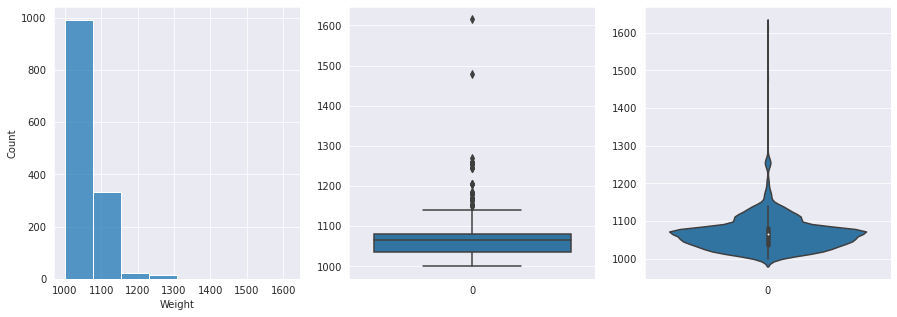

In [35]:
graficar_info_variable(df.Weight)

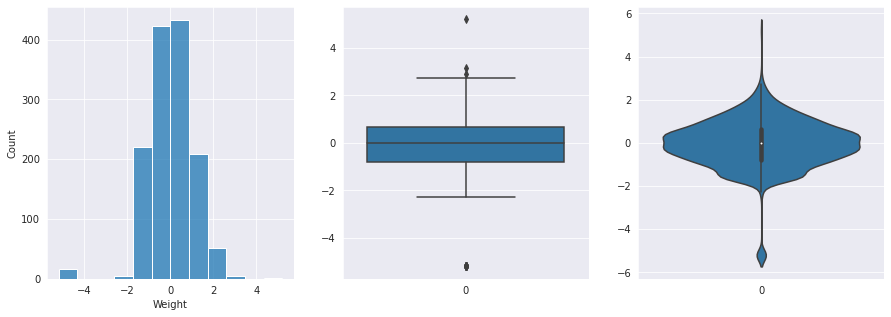

In [36]:
df.Weight = qt.fit_transform(df.Weight.values.reshape(-1, 1))
graficar_info_variable(df.Weight, 12)

In [37]:
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  1.396032329169728


In [38]:
df = quitar_outliers(df, df.Weight)
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  0.22354694485842028


##### Matriz de Correlacion

In [39]:
df.corr().style.background_gradient(cmap='Greens')

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,CNG,Diesel,Petrol
Price,1.000000,-0.874328,0.006465,0.882721,-0.603982,0.187511,0.088540,0.028908,0.101351,0.175709,0.033989,0.148271,0.470639,0.254281,0.043157,0.079725,0.346124,0.089816,0.288455,0.436267,0.397969,0.623532,0.452226,0.323951,0.326627,0.056554,-0.025808,0.209014,0.057692,0.135330,0.018465,-0.027983,-0.144037,-0.027080,0.002561,0.007351
Age_08_04,-0.874328,1.000000,-0.153390,-0.980749,0.535505,-0.067234,-0.094107,0.049025,-0.081541,-0.115401,0.015062,-0.175915,-0.416789,-0.188997,-0.009444,-0.055091,-0.416236,-0.094896,-0.343739,-0.372416,-0.330675,-0.717625,-0.480717,-0.233648,-0.230456,-0.056648,0.004035,-0.093314,-0.070637,-0.135089,0.029033,0.003081,0.163366,-0.014601,-0.075904,0.077004
Mfg_Month,0.006465,-0.153390,1.000000,-0.042527,-0.019185,-0.035611,0.026433,0.002387,0.046077,-0.009593,-0.004327,0.069131,0.053963,-0.010507,0.001921,-0.002561,0.071664,0.007488,0.065744,0.057487,-0.034974,0.018911,-0.020624,0.022983,0.038806,-0.059488,0.030257,-0.033538,0.057117,0.022886,0.035471,0.031327,-0.048430,0.007189,0.081864,-0.079962
Mfg_Year,0.882721,-0.980749,-0.042527,1.000000,-0.537636,0.075015,0.089924,-0.050039,0.073338,0.118573,-0.014373,0.164200,0.410735,0.193164,0.009169,0.056206,0.406678,0.094466,0.334549,0.365175,0.341243,0.721825,0.490109,0.231690,0.225337,0.069030,-0.010058,0.100973,0.060131,0.132060,-0.036364,-0.009306,-0.155603,0.013342,0.060567,-0.062054
KM,-0.603982,0.535505,-0.019185,-0.537636,1.000000,-0.233370,-0.043553,-0.072409,0.069732,-0.022833,0.043199,0.250207,-0.010220,-0.202406,-0.001785,-0.076835,-0.182399,-0.011125,-0.156559,-0.143430,-0.242005,-0.372718,-0.250589,-0.119966,-0.131806,0.000813,0.009939,-0.063861,-0.029393,-0.068876,0.032732,0.012598,0.102278,0.129565,0.344032,-0.371888
HP,0.187511,-0.067234,-0.035611,0.075015,-0.233370,1.000000,0.047444,0.008273,0.035125,0.118976,0.125502,-0.379311,0.077703,0.146843,0.006145,0.054117,0.034738,0.003437,0.007818,0.236832,0.158442,0.095327,0.057970,0.258657,0.262313,0.041747,0.013185,0.206419,-0.052094,0.004437,0.144601,0.011793,0.113461,0.073921,-0.611375,0.551122
Met_Color,0.088540,-0.094107,0.026433,0.089924,-0.043553,0.047444,1.000000,-0.024766,0.037779,0.083131,0.023536,0.016181,0.083300,0.148658,0.017849,-0.014979,0.009292,0.111451,0.027938,0.109950,0.002365,0.084075,0.187319,0.153426,0.143775,0.093575,0.086043,0.023384,-0.007209,0.040823,0.047871,0.084758,0.155543,0.017729,0.004197,-0.010364
Automatic,0.028908,0.049025,0.002387,-0.050039,-0.072409,0.008273,-0.024766,1.000000,0.073795,-0.027243,-0.102193,-0.052952,0.091863,0.025861,0.016110,0.018342,-0.023227,-0.017138,-0.008770,-0.038912,0.054908,-0.058242,-0.027075,-0.003469,-0.008846,-0.008462,-0.009255,-0.007060,0.004977,-0.037776,-0.079599,-0.008761,0.016572,0.003163,-0.075893,0.070584
cc,0.101351,-0.081541,0.046077,0.073338,0.069732,0.035125,0.037779,0.073795,1.000000,0.076794,0.007772,0.281433,0.347699,-0.048490,-0.082625,-0.009848,0.032587,0.016708,0.022647,0.099362,0.150777,-0.004090,0.052630,0.058316,0.043941,0.022435,-0.001233,0.010380,-0.047063,-0.072684,-0.012237,-0.001389,0.010996,0.007950,0.294856,-0.281529
Doors,0.175709,-0.115401,-0.009593,0.118573,-0.022833,0.118976,0.083131,-0.027243,0.076794,1.000000,-0.156764,0.105275,0.436828,0.036444,-0.005444,0.041374,0.058647,0.044634,0.019538,0.162443,0.017591,0.071953,0.075204,0.122549,0.099142,0.055575,0.000463,0.061097,-0.147150,-0.020546,-0.058068,0.000495,0.119008,0.005532,0.009052,-0.010551


#### Univariate Feature Selection

In [40]:
m = SelectKBest(score_func=f_regression, k=4)
r = m.fit(x, y)
results_df=pd.DataFrame(r.scores_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'])

,Feature,Score
1,Mfg_Month,0.471934
13,BOVAG_Guarantee,1.135864
6,Automatic,1.570992
34,Petrol,2.130519
32,CNG,2.245020
25,Radio,2.520447
30,Radio_cassette,2.678580
33,Diesel,4.206904
9,Gears,5.733157
24,Power_Steering,5.948894


In [41]:
columns = ['Mfg_Year', 'Age_08_04', 'Boardcomputer','Automatic_airco', 'Weight', 'KM', 'CD_Player', 'Airco', 'Powered_Windows',
           'Central_Lock', 'HP', 'ABS', 'Price']

In [42]:
df = df[columns]

In [43]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [44]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
x.Mfg_Year = standar_scaler.fit_transform(x.Mfg_Year.values.reshape(-1, 1))
x.Age_08_04 = standar_scaler.fit_transform(x.Age_08_04.values.reshape(-1, 1))
x.HP = standar_scaler.fit_transform(x.HP.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.4189


In [46]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     484.0
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:47:54   Log-Likelihood:                -417.24
No. Observations:                 939   AIC:                             860.5
Df Residuals:                     926   BIC:                             923.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1250      0.038     -3.288      0.001      -0.200      -0.050
Mfg_Year            0.5442      0.065      8.335      0.000       0.416       0.672
Age_08_04          -0.1266      0.065     -1.953      0.051      -0.254       0.001
Boardcomputer      -0.1000      0.041     -2.438      0.015      -0.181      -0.019
Automatic_airco     0.2292      0.068      3.353      0.001       0.095       0.363
Weight              0.1718      0.015     11.419      0.000       0.142       0.201
KM                 -0.2256      0.016    -14.274      0.000      -0.257      -0.195
CD_Player           0.0181      0.036      0.509      0.611      -0.052       0.088
Airco               0.1433      0.032      4.412      0.000       0.080       0.207
Powered_Windows     0.0518      0.050      1.044      0.297      -0.046       0.149
Central_Lock        0.0588      0.050      1.178      0.239      -0.039       0.157
HP                  0.0308      0.014      2.233      0.026       0.004       0.058
ABS                 0.0070      0.035      0.199      0.842      -0.062       0.076
==============================================================================
Omnibus:                       25.514   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.085
Skew:                          -0.139   Prob(JB):                     1.33e-11
Kurtosis:                       4.097   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
columns_final = ['Mfg_Year','Automatic_airco', 'Weight', 'KM', 'Airco','HP']

In [49]:
x_final = x[columns_final]

#### Guardar modelos mlflow

In [50]:
mlflow.set_tracking_uri('http://66.97.41.26:8080/')
experiment_name = "dataset_toyota_corolla"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(name=experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

##### Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [87]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    linear_regression = LinearRegression()
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    r2 = cross_val_score(linear_regression, x_final, y, scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x_final, y, scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    linear_regression.fit(x_final, y)
    signature = infer_signature(x_final, linear_regression.predict(x_final))
    mlflow.log_param("n_features", len(columns_final))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(linear_regression, "linear_regression_log_price", signature=signature)

/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [88]:
r2, rmse

(0.8388994728105841, 0.3987254075395968)

##### Lasso

In [44]:
from sklearn.linear_model import LassoCV

In [45]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    lasso = LassoCV(cv=5, random_state=0)
    r2 = cross_val_score(lasso, x_final, y.ravel(), scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x_final, y.ravel(), scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    lasso.fit(x_final, y.ravel())
    signature = infer_signature(x_final, lasso.predict(x_final))
    mlflow.log_param("n_features", len(columns_final))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(lasso, "lasso_log_price", signature=signature)

/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [46]:
r2, rmse

(0.8440834405550477, 0.39200032419123615)

In [ ]:
names = pd.DataFrame(x_final.columns)
results_df=pd.DataFrame(lasso.coef_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Coef"]
scored.sort_values(by=['Coef'])

##### Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.2, random_state=42)

In [49]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['1.0', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 2, 4, 5, 6, 7, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [50]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    random_forest_regressor = RandomForestRegressor()
    best_random_forest = RandomizedSearchCV(
        estimator = random_forest_regressor,
        param_distributions = random_grid,
        n_iter = 100,
        cv = 3,
        verbose=2,
        random_state=42,
        n_jobs = -1)
    best_random_forest.fit(x_train, y_train.ravel())
    r2 = best_random_forest.score(x_train, y_train)
    rmse = mean_squared_error(y_test, best_random_forest.predict(x_test), squared=False)
    signature = infer_signature(x_train, best_random_forest.predict(x_train))
    mlflow.log_param("n_features", len(columns_final))
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(random_forest_regressor, "random_forest_regressor_log_price", signature=signature)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
69 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(it

In [51]:
r2, rmse

(0.8928293826364772, 0.32044010430224285)

#### Aplicando PCA

In [52]:
from sklearn.decomposition import PCA

In [82]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(x)

##### Linear regression

In [83]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    linear_regression = LinearRegression()
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    r2 = cross_val_score(linear_regression, x_pca, y, scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x_pca, y, scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    linear_regression.fit(x_pca, y)
    signature = infer_signature(x_pca, linear_regression.predict(x_pca))
    mlflow.log_param("n_comp_pca", pca.n_components)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(linear_regression, "linear_regression_log_price", signature=signature)

In [84]:
r2, rmse

(0.8395563083829043, 0.39803362795676217)

##### Random Forest

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

In [61]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    random_forest_regressor = RandomForestRegressor()
    best_random_forest = RandomizedSearchCV(
        estimator = random_forest_regressor,
        param_distributions = random_grid,
        n_iter = 100,
        cv = 3,
        verbose=2,
        random_state=42,
        n_jobs = -1)
    best_random_forest.fit(x_train, y_train.ravel())
    r2 = best_random_forest.score(x_train, y_train)
    rmse = mean_squared_error(y_test, best_random_forest.predict(x_test), squared=False)
    signature = infer_signature(x_train, best_random_forest.predict(x_train))
    mlflow.log_param("n_comp_pca", pca.n_components)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(random_forest_regressor, "random_forest_regressor_log_price", signature=signature)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
69 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(it

In [62]:
r2, rmse

(0.9369435071576129, 0.33511305452253554)

#### Gráficos

In [117]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [118]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.3763


In [121]:
df.corr().style.background_gradient(cmap='Greens')

,Mfg_Year,Automatic_airco,Weight,KM,Airco,HP,Price
Mfg_Year,1.000000,0.403836,0.460229,-0.560440,0.382842,0.137479,0.878975
Automatic_airco,0.403836,1.000000,0.354435,-0.276009,0.229584,0.237724,0.477344
Weight,0.460229,0.354435,1.000000,-0.060111,0.358272,0.153401,0.512881
KM,-0.560440,-0.276009,-0.060111,1.000000,-0.163190,-0.259433,-0.625980
Airco,0.382842,0.229584,0.358272,-0.163190,1.000000,0.243670,0.446721
HP,0.137479,0.237724,0.153401,-0.259433,0.243670,1.000000,0.283145
Price,0.878975,0.477344,0.512881,-0.625980,0.446721,0.283145,1.000000


In [51]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

In [59]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:ylabel='Count'>

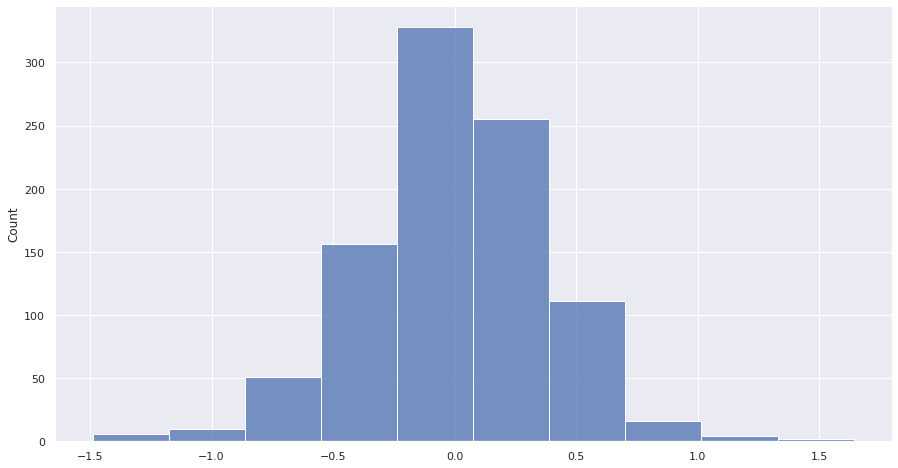

In [60]:
# Residuales
sns.histplot(ml_results.resid, bins=10)

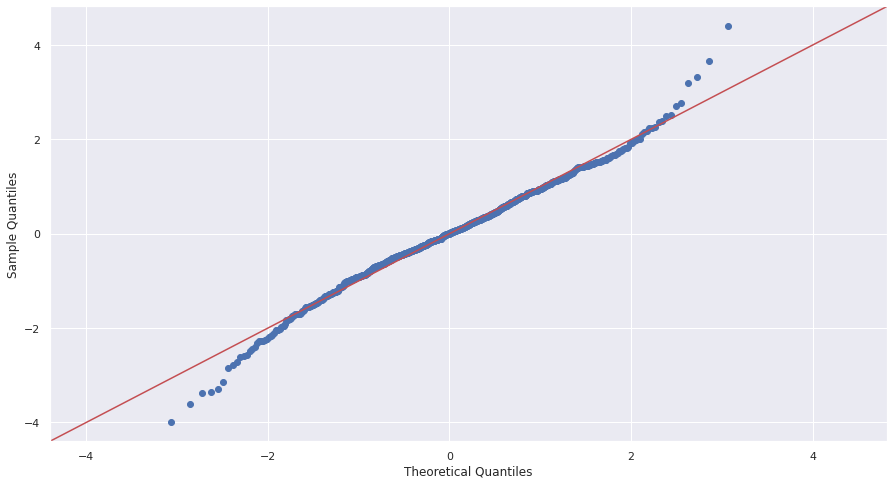

In [61]:
def grafico_qqplot():
    fig = sm.qqplot(lm_resid_stand,line='45')
    plt.show()

grafico_qqplot()

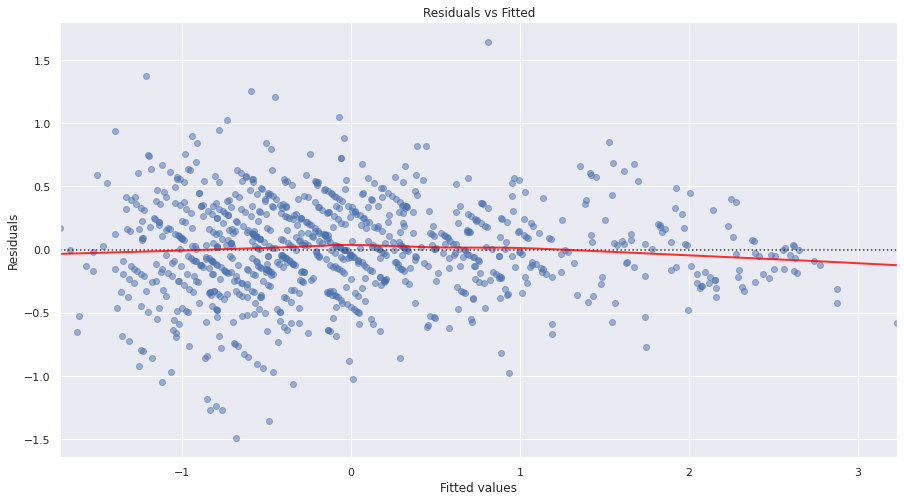

In [62]:
def residuales_vs_ajustados():
    plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                         scatter_kws={'alpha': 0.5},
                         line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

    # Titel and labels
    plot.set_title('Residuals vs Fitted')
    plot.set_xlabel('Fitted values')
    plot.set_ylabel('Residuals')
residuales_vs_ajustados()